<h1>Model Input Selection</h1>

In this Notebook we decide on the model input data. \
The usual suspects of text data modelling techniques are: CBOW, TF-IDF and Word Vectors (here we use GloVe - 6b.300d). \
Since we are only deciding the best vector space representation, we will use Naive - bayes model because it is fast and effective enough in text data cases.\
The performance metric used is AUC - ROC, since the dataset is highly imbalanced with positive case (abuse) only at around $\approx 10\%$  

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import auc
from sklearn.metrics import roc_ac_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_colwidth", 1000)

from sklearn.preprocessing import LabelEncoder

# Engineered Features

This Notebook analysis the competency of the engineered features in discriminating the messages between Abuse and Non - Abuse.\
The method chosen is as described below:
 - Only considers the features that showed some promise from past analysis on features extracted from pre-clean and post-clean data seperately.
 - Performs multivariate analysis by using models to decide on the feature importances.
 - Used models both (Linear and Non - linear) using all of the combined features and selected features.
 - RFE was used in selecting top three Features among the Engineered features.

In [5]:
pre_clean_features = ['stop_word_count', 'unique_vs_words' , 'upper_case_words', 'numeric_count', 'Upper_case_vs_words']
post_clean_features = ['conjunction','other','adposition', 'adverb', 'pronoun', 'verb']

In [6]:
train_pre_clean = pd.read_csv("../cleaned_data/train_pre_clean_features.csv", encoding="utf-8")\
                    .drop(columns=['message'])\
                    .reset_index(drop=True)



train_post_clean = pd.read_csv("../cleaned_data/train_post_clean_features.csv", encoding="utf-8", header=0)
train_post_clean = train_post_clean.drop(index=train_post_clean[train_post_clean.adjective == 'adjective'].index)\
                    .apply(lambda x: pd.to_numeric(x, errors='coerce'))\
                    .reset_index(drop=True)

combined_features_eng = train_pre_clean.merge(train_post_clean, how='inner', left_index=True, right_index=True)
combined_features_eng = combined_features_eng.loc[:, pre_clean_features + post_clean_features + ['label']]

In [44]:
del train_post_clean, train_pre_clean

In [7]:
combined_features_eng.head()

,stop_word_count,unique_vs_words,upper_case_words,numeric_count,Upper_case_vs_words,conjunction,other,adposition,adverb,pronoun,verb,label
0,22,0.894737,0,0,0.000000,0,1,0,0,0,2,no_abuse
1,9,0.952381,0,0,0.000000,0,0,0,1,0,2,no_abuse
2,5,0.923077,0,0,0.000000,0,0,0,0,0,0,no_abuse
3,37,0.831461,5,1,0.056180,0,2,1,2,0,6,abuse
4,75,0.697531,3,2,0.018519,0,1,1,4,0,10,no_abuse


In [13]:
combined_features_eng = combined_features_eng.sample(n=100000, random_state=42).reset_index(drop=True)

In [14]:
train_index, test_index = train_test_split(combined_features_eng.index, stratify=combined_features_eng.label)

In [15]:
# columns to Standard scale
scale_cols_list = list(combined_features_eng.columns)
scale_cols_list.remove('label')

for col in scale_cols_list:
    combined_features_eng.loc[train_index, col] = StandardScaler().fit_transform(combined_features_eng.loc[train_index, col].values.reshape(-1,1))

In [31]:
label_encoder = LabelEncoder()

In [52]:
def plot_auc(train_fpr, train_tpr, test_fpr, test_tpr,
             train_auc, test_auc, title="ROC Curve"):    
    
    plt.plot(train_fpr, train_tpr, label=f'Train AUC = {round(train_auc, 3)}')
    plt.plot(test_fpr, test_tpr, label=f'Test AUC = {round(test_roc_auc, 2)}')
    
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    plt.legend()
    plt.title("ROC Curve")
    plt.grid()

    plt.show()

### Decision Tree

In [16]:
min_samples = [2,3,5,7,9, 15, 21]

param_grid = {'max_depth': np.arange(2,11), 'min_samples_split': min_samples}
performance_metric = {'auc': 'roc_auc'}

In [19]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced', random_state=1),
                  param_grid=param_grid, scoring=performance_metric,
                  refit='auc', return_train_score=True)

In [ ]:
gs.fit(combined_features_eng.loc[train_index, pre_clean_features+post_clean_features], 
       label_encoder.fit_transform(combined_features_eng.loc[train_index, 'label']));

In [33]:
gs.best_params_
gs.best_score_

{'max_depth': 7, 'min_samples_split': 9}

In [51]:
train_probs = gs.best_estimator_.predict_proba(combined_features_eng.loc[train_index, pre_clean_features+post_clean_features])
train_preds = train_probs[:,1]

train_fpr, train_tpr, train_threshold = roc_curve(label_encoder.transform(combined_features_eng.loc[train_index, 'label']), train_preds)
train_roc_auc = auc(train_fpr, train_tpr)

In [36]:
tuned_DT = CalibratedClassifierCV(gs.best_estimator_, cv="prefit")\
            .fit(combined_features_eng.loc[train_index, pre_clean_features+post_clean_features], 
                  label_encoder.transform(combined_features_eng.loc[train_index, 'label'])
                )

In [37]:
test_probs = tuned_DT.predict_proba(combined_features_eng.loc[test_index, pre_clean_features+post_clean_features])
test_preds = probs[:,1]

In [50]:
test_fpr, test_tpr, test_threshold = roc_curve(label_encoder.transform(combined_features_eng.loc[test_index, 'label']), preds)
test_roc_auc = auc(test_fpr, test_tpr)

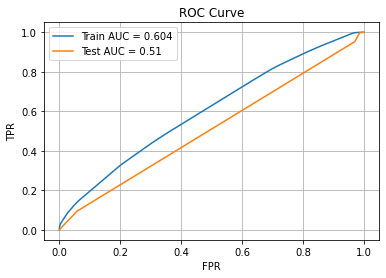

In [53]:
plot_auc(train_fpr, train_tpr, test_fpr, test_tpr,
         train_roc_auc, test_roc_auc)

In [68]:
print('Feature Importance')
print("-"*50)

pd.Series(gs.best_estimator_.feature_importances_, index=pre_clean_features+post_clean_features).sort_values(ascending=False)

Feature Importance
--------------------------------------------------


stop_word_count        0.319240
upper_case_words       0.158767
numeric_count          0.136805
unique_vs_words        0.131752
Upper_case_vs_words    0.129386
adverb                 0.031255
conjunction            0.029337
other                  0.027225
verb                   0.016538
pronoun                0.016028
adposition             0.003667
dtype: float64

### Logistic Regression

In [69]:
C = [1e+05, 1e+04, 1e+03, 1e+02, 1e+01, 1, 1e-01, 1e-02, 1e-03]

In [79]:
param_grid = {'C': C, 'penalty': ['l1', 'l2']}
performance_metric = {'auc': 'roc_auc'}
refit_metric = 'auc'

In [99]:
def tune_model(param_grid, performance_metric, refit_metric, base_estimator, feature_columns):
    
    # DecisionTreeClassifier(class_weight='balanced', random_state=1)
    # refit='auc'
    # pre_clean_features+post_clean_features
    gs = GridSearchCV(estimator=base_estimator,
                  param_grid=param_grid, scoring=performance_metric,
                  refit='auc', return_train_score=True)\
        .fit(combined_features_eng.loc[train_index, feature_columns], 
               label_encoder.fit_transform(combined_features_eng.loc[train_index, 'label'])
              );
    
    
    train_probs = gs.best_estimator_.predict_proba(combined_features_eng.loc[train_index, feature_columns])
    train_preds = train_probs[:,1]

    train_fpr, train_tpr, train_threshold = roc_curve(label_encoder.transform(combined_features_eng.loc[train_index, 'label']), train_preds)
    train_roc_auc = auc(train_fpr, train_tpr)
    
    
    tuned_DT = CalibratedClassifierCV(gs.best_estimator_, cv="prefit")\
            .fit(combined_features_eng.loc[train_index, feature_columns], 
                  label_encoder.transform(combined_features_eng.loc[train_index, 'label'])
                )
    
    test_probs = tuned_DT.predict_proba(combined_features_eng.loc[test_index, feature_columns])
    test_preds = probs[:,1]
    
    test_fpr, test_tpr, test_threshold = roc_curve(label_encoder.transform(combined_features_eng.loc[test_index, 'label']), preds)
    test_roc_auc = auc(test_fpr, test_tpr)
    
    return train_fpr, train_tpr, train_roc_auc, \
           test_fpr, test_tpr, test_roc_auc,\
           gs.best_estimator_

In [75]:
from sklearn import linear_model

In [76]:
base_estimator = linear_model.LogisticRegression(class_weight='balanced')

In [83]:
train_fpr, train_tpr, train_roc_auc,\
test_fpr, test_tpr, test_roc_auc,
best_model = tune_model(param_grid, performance_metric, refit_metric,
                        base_estimator, pre_clean_features+post_clean_features)

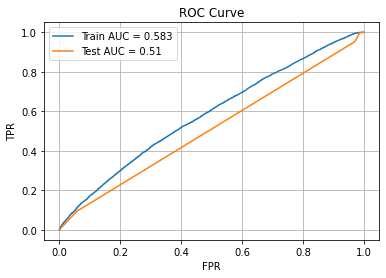

In [84]:
plot_auc(train_fpr, train_tpr, test_fpr, test_tpr,
         train_roc_auc, test_roc_auc)

In [91]:
best_model[-1]

LogisticRegression(C=10000.0, class_weight='balanced')

### RFE

In [103]:
from sklearn.feature_selection import RFECV

In [115]:
base_estimator = DecisionTreeClassifier(class_weight='balanced', random_state=1)

selector = RFECV(base_estimator, step=1, cv=5, scoring='roc_auc')

selector = selector.fit(combined_features_eng.loc[train_index, scale_cols_list],
                        combined_features_eng.loc[train_index, 'label'])

In [119]:
combined_features_eng.loc[:, scale_cols_list].loc[:,selector.get_support()].columns

Index(['stop_word_count', 'unique_vs_words', 'Upper_case_vs_words'], dtype='object')

### Model with important features

In [121]:
important_features = ['stop_word_count', 'unique_vs_words', 'Upper_case_vs_words']

In [122]:
min_samples = [2,3,5,7,9, 15, 21]

param_grid = {'max_depth': np.arange(2,11), 'min_samples_split': min_samples}
performance_metric = {'auc': 'roc_auc'}

base_estimator = DecisionTreeClassifier(class_weight='balanced', random_state=1)

In [123]:
train_fpr, train_tpr, train_roc_auc,\
test_fpr, test_tpr, test_roc_auc,
best_model = tune_model(param_grid, performance_metric, refit_metric,
                        base_estimator, important_features
                       )

In [124]:
best_model[-1]

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=21, random_state=1)

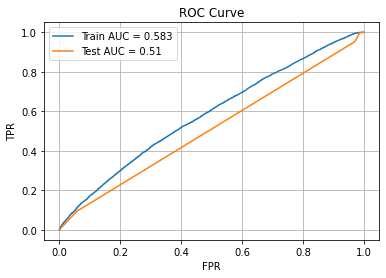

In [125]:
plot_auc(train_fpr, train_tpr, test_fpr, test_tpr,
         train_roc_auc, test_roc_auc)

### Engineered feature performance

Model |features used | train AUC | test AUC
------| ----------|--------- |-----------
Decision Tree | All Features | 0.60 | 0.51
Logistic Regression | All Features | 0.58 | 0.51
Decision Tree - important Features | stop_word_count, unique_vs_words, Upper_case_vs_words | 0.58 | 0.51

Thus, we see that the models with Engineered features only performs very slightly better than Random Model (0.5). \
This indicates that the **engineered features** are **not very good predictors**.